# Projet : Analyse de sentiments sur des tweets

In [ ]:
!pip install evaluate

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [7]:
# Chargement du dataset TweetEval en mode emotion (label :  0: anger, 1: joy, 2: optimism, 3: sadness)
data = load_dataset("tweet_eval", "emotion")
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

emotion/train-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

emotion/test-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

emotion/validation-00000-of-00001.parque(…):   0%|          | 0.00/28.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [8]:
# Chargement du tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [9]:
# Tokenization du texte
def tokenization(batch):
  return tokenizer(batch["text"], padding="max_length", truncation=True)

tokenized_data = data.map(tokenization, batched=True)
tokenized_data

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 374
    })
})

In [10]:
# Préparation du modèle
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [11]:
# Définition des métriques
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1_score  = f1.compute(predictions=preds, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "f1": f1_score ["f1"]}

In [12]:
# Préparation de l'entraînement
training_args = TrainingArguments(
    seed=42,
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to='none',
    logging_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1946833690.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# Evaluation du modèle avant entraînement
trainer.evaluate(tokenized_data["test"])

{'eval_loss': 1.4169636964797974,
 'eval_model_preparation_time': 0.0044,
 'eval_accuracy': 0.258972554539057,
 'eval_f1': 0.14109204613835882,
 'eval_runtime': 23.4725,
 'eval_samples_per_second': 60.539,
 'eval_steps_per_second': 3.792}

Le résultat avant l’entraînement est mauvais : la précision est de 16 % et le F1-macro est de 13 %.

In [14]:
# Entraînement du modèle
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,0.904900,0.667447,0.004400,0.754011,0.641106
2,0.495700,0.628019,0.004400,0.772727,0.708562
3,0.353700,0.606486,0.004400,0.791444,0.733159


TrainOutput(global_step=612, training_loss=0.584806866115994, metrics={'train_runtime': 498.9183, 'train_samples_per_second': 19.584, 'train_steps_per_second': 1.227, 'total_flos': 1294385117663232.0, 'train_loss': 0.584806866115994, 'epoch': 3.0})

In [15]:
# Evaluation du modèle après entraînement
trainer.evaluate(tokenized_data["test"])

{'eval_loss': 0.5597118735313416,
 'eval_model_preparation_time': 0.0044,
 'eval_accuracy': 0.8036593947923997,
 'eval_f1': 0.757245542258383,
 'eval_runtime': 23.2007,
 'eval_samples_per_second': 61.248,
 'eval_steps_per_second': 3.836,
 'epoch': 3.0}

Le résultat après l’entraînement est correct : la précision est de 80 % et le F1-macro est de 76 %.

In [16]:
# Sauvegarde du modèle
model.save_pretrained("./models/distilbert_emotion")
tokenizer.save_pretrained("./models/distilbert_emotion")

('./models/distilbert_emotion/tokenizer_config.json',
 './models/distilbert_emotion/special_tokens_map.json',
 './models/distilbert_emotion/vocab.txt',
 './models/distilbert_emotion/added_tokens.json',
 './models/distilbert_emotion/tokenizer.json')

# Testons notre modèle sur des phrases personnalisées :

Méthode classique :

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [14]:
# Chargement du modèle ainsi que du tokenizer
model_path = "./models/distilbert_emotion"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [15]:
# Création du pipeline d'inférence
emotion_analyzer = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [16]:
# Testons avec une phrase personnalisée (label :  0: anger, 1: joy, 2: optimism, 3: sadness)
text = "I'm really happy today!"
result = emotion_analyzer(text)[0]
result

[{'label': 'LABEL_0', 'score': 0.012323558330535889},
 {'label': 'LABEL_1', 'score': 0.9318702220916748},
 {'label': 'LABEL_2', 'score': 0.02934032864868641},
 {'label': 'LABEL_3', 'score': 0.026465803384780884}]

In [17]:
# Modifions les noms des labels pour plus de clarté
def change_labels(result):
  labels = ["anger", "joy", "optimism", "sadness"]
  copy = result.copy()
  for i in range(len(copy)):
    copy[i]["label"] = labels[i]
  return copy

result = change_labels(result)
result

[{'label': 'anger', 'score': 0.012323558330535889},
 {'label': 'joy', 'score': 0.9318702220916748},
 {'label': 'optimism', 'score': 0.02934032864868641},
 {'label': 'sadness', 'score': 0.026465803384780884}]

In [18]:
# Affichage de la meilleure émotion
best_emotion = max(result, key=lambda x: x['score'])
best_emotion

{'label': 'joy', 'score': 0.9318702220916748}

In [19]:
# Testons avec une deuxième phrase
text2 = "I feel so sad..."
result2 = max(change_labels(emotion_analyzer(text2)[0]), key=lambda x: x['score'])
result2

{'label': 'sadness', 'score': 0.9549025893211365}

Avec PyTorch (Recommandée) :

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

In [ ]:
# Chargement du modèle ainsi que du tokenizer
model_path = "./models/distilbert_emotion"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
# Mode évaluation
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Fonction de prédiction :
labels = ["anger", "joy", "optimism", "sadness"]
def predict_emotion(text):
  inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True)
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()
    confidence = torch.max(probs, dim=-1).values.item()
  return labels[pred_class], float(confidence)

In [ ]:
# Testons avec une phrase personnalisée
text = "I'm really happy today!"
emotion, confidence = predict_emotion(text)
print("Emotion prédite :", emotion, ", confiance : ", confidence)

Emotion prédite : joy , confiance :  0.928260326385498


In [ ]:
# Testons avec une deuxième phrase
text2 = "I feel so sad..."
emotion2, confidence2 = predict_emotion(text2)
print("Emotion prédite :", emotion2, ", confiance : ", confidence2)

Emotion prédite : sadness , confiance :  0.9528851509094238


Avec TensorFlow :

Les nouvelles versions de Transformers ne prenant plus en charge TensorFlow, nous sommes donc obligés d’utiliser une version antérieure.

In [ ]:
!pip install transformers==4.44.2

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# Chargement du modèle ainsi que du tokenizer
model_path = "./models/distilbert_emotion"
model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
# Fonction de prédiction
labels = ["anger", "joy", "optimism", "sadness"]
def predict_emotion(text):
  inputs = tokenizer(text, return_tensors="tf", padding="max_length", truncation=True)
  outputs = model(**inputs)
  logits = outputs.logits
  probs = tf.nn.softmax(logits, axis=-1)
  pred_class = tf.argmax(probs, axis=-1).numpy()[0]
  confidence = tf.reduce_max(probs, axis=-1).numpy()[0]
  return labels[pred_class], float(confidence)

In [ ]:
# Testons avec une phrase personnalisée
text = "I'm really happy today!"
emotion, confidence = predict_emotion(text)
print("Emotion prédite :", emotion, ", confiance : ", confidence)

Emotion prédite : joy , confiance :  0.9282602667808533


In [ ]:
# Testons avec une deuxième phrase
text2 = "I feel so sad..."
emotion2, confidence2 = predict_emotion(text2)
print("Emotion prédite :", emotion2, ", confiance : ", confidence2)

Emotion prédite : sadness , confiance :  0.9528852105140686


Nous pouvons remarquer que les résultats de chaque méthodes sont différentes. Cela est normal, car leurs implémentations diffèrent et la conversion n’est pas la même.

# Matrice de confusion :

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Prédictions du modèle
pred = trainer.predict(tokenized_data['test'])

In [25]:
# Initialisation des données nécessaires à la matrice
labels = pred.label_ids
predictions = np.argmax(pred.predictions,axis=1)
labels_names = ["anger", "joy", "optimism", "sadness"]

In [26]:
# Matrice de confusion :
cm = confusion_matrix(labels, predictions)
cm

array([[480,  24,  11,  43],
       [ 22, 296,  12,  28],
       [ 26,  22,  58,  17],
       [ 41,  28,  10, 303]])

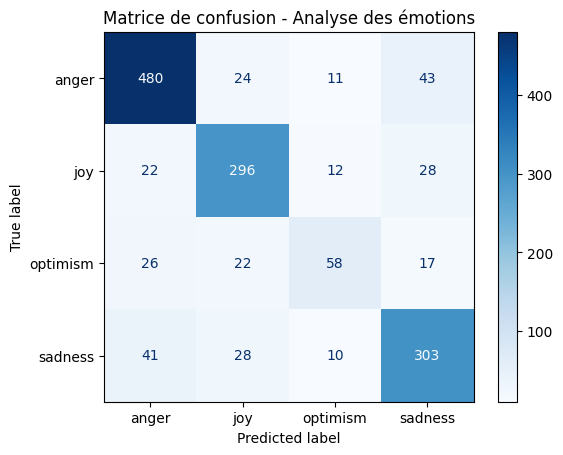

In [27]:
# Affichage graphique
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matrice de confusion - Analyse des émotions")
plt.show()

La matrice de confusion révèle une très bonne performance globale du modèle, notamment pour les classes *anger*, *joy* et *sadness*. En revanche, la classe *optimism* présente un taux d'erreur plus élevé, ce qui s'explique par son caractère abstrait et son ambiguïté sémantique, souvent proche de la joie ou de l'espoir mêlé à de la tristesse.

On observe notamment :
- une confusion entre *anger* et *sadness* (émotions négatives proches),
- une difficulté à distinguer *optimism* de *joy*,
- peu de confusions graves (ex : *joy* ≠ *anger* dans la majorité des cas).

Ces résultats renforcent la robustesse du modèle tout en mettant en évidence les limites naturelles de la classification émotionnelle.


# Visualiser les tokens importants :

In [24]:
import torch
import matplotlib.pyplot as plt

In [25]:
# Récupération des attentions du modèle
text = "I feel so sad..."
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True)

# Envoi sur le même device que le modèle pour éviter l'érreur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

In [26]:
# Moyenne des têtes d'attention et extraction
last_attention = attentions[-1]
mean_attention = torch.mean(last_attention, dim=1)[0]

In [27]:
# Attention moyenne **pour chaque token par rapport à tous les autres**
attention_scores = mean_attention.mean(dim=0).detach().cpu().numpy()

In [28]:
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

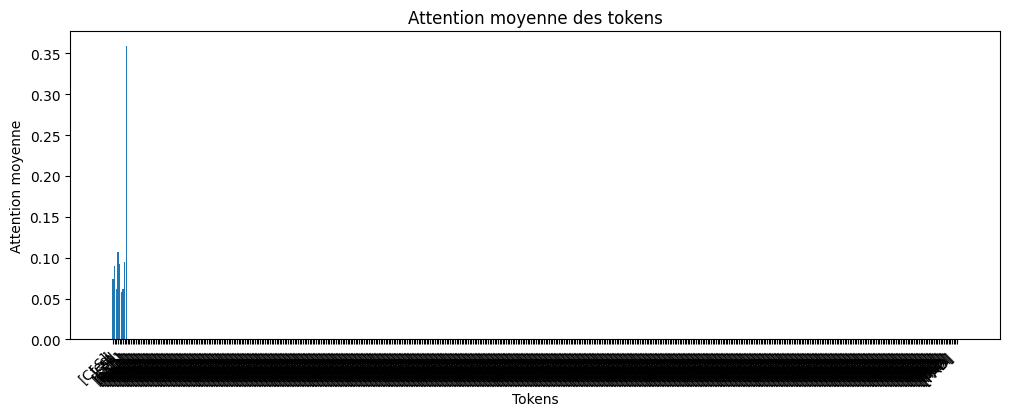

In [32]:
# Affichage graphique des tokens importants
plt.figure(figsize=(12, 4))
plt.bar(range(len(tokens)), attention_scores)
plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
plt.xlabel("Tokens")
plt.ylabel("Attention moyenne")
plt.title("Attention moyenne des tokens")
plt.show()

Suppression des tokens inutiles de l'affichage :

In [33]:
tokens_filtered = []
attention_filtered = []

for t, score in zip(tokens, attention_scores):
  if t not in tokenizer.all_special_tokens:
    tokens_filtered.append(t)
    attention_filtered.append(score)

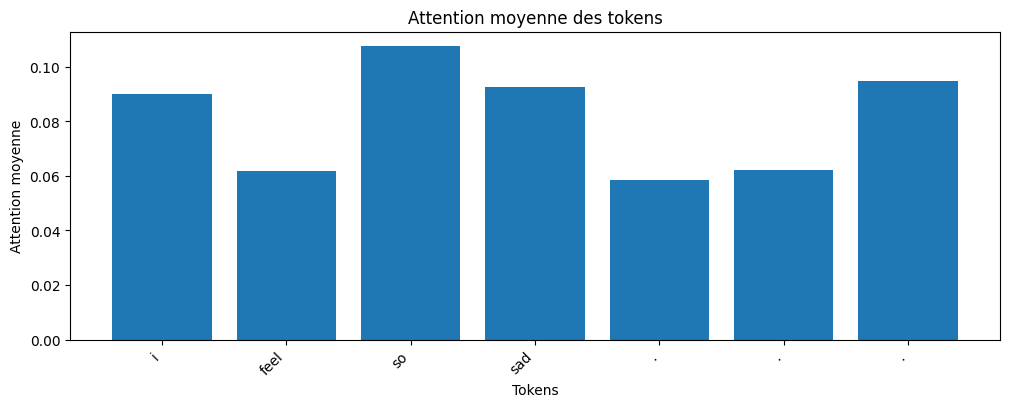

In [35]:
# Affichage graphique des tokens importants
plt.figure(figsize=(12, 4))
plt.bar(range(len(tokens_filtered)), attention_filtered)
plt.xticks(range(len(tokens_filtered)), tokens_filtered, rotation=45, ha="right")
plt.xlabel("Tokens")
plt.ylabel("Attention moyenne")
plt.title("Attention moyenne des tokens")
plt.show()